In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 
import tqdm

import torch, torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

## Data preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root=r'D:\DataScience\ONU\datasets\cifar10', 
                                        train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root=r'D:\DataScience\ONU\datasets\cifar10', 
                                       train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=4)

test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Some images from a random batch

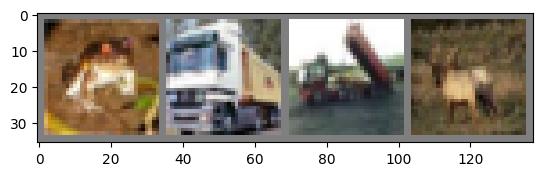

frog  truck truck deer 


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [4]:
print(f'Number of train batches: {len(train_loader)}')
print(f'Number of test  batches: {len(test_loader)}')
print(f'Total number of batches: {len(train_loader) + len(test_loader)}')

Number of train batches: 391
Number of test  batches: 79
Total number of batches: 470


## **1. Implementing ResNet block**

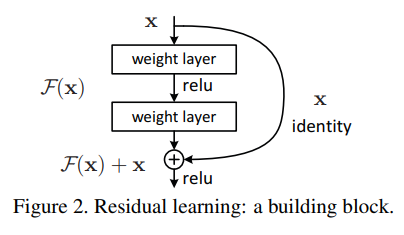

#### From paper https://arxiv.org/pdf/1512.03385 (page 4)

_"_

---

_We adopt batch normalization (BN) [16] right after each 
convolution and before activation, following [16]._

_We initialize the weights as in [13] and train all plain/residual nets from scratch. We
use SGD with a mini-batch size of 256._

_The learning rate starts from 0.1 and is divided by 10 when the error 
plateaus, and the models are trained for up to 60 × 104 iterations._

_We use a weight decay of 0.0001 and a momentum of 0.9. 
We do not use dropout [14], following the practice in [16]._

---

_When the dimensions increase (dotted line shortcuts in Fig. 3), we consider two options:_

_(A) The shortcut still performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra parameter;_ 

_(B) The projection shortcut in Eqn.(2) is used to
match dimensions (done by 1×1 convolutions)._ 

_For both options, when the shortcuts go across feature maps of 
two sizes, they are performed with a stride of 2._

---

_"_

In [5]:
class ResNetBlock(nn.Module):
    """
    Implements ResNet block for models with num < 50
    (resnet10, resnet18, resnet20, ... etc)

    'last_relu' parameter may disappear
    """
    def __init__(self, in_channels, out_channels, last_relu=True, conv1_stride=1):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=3, padding=1, stride=conv1_stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 
                      kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # https://colab.research.google.com/github/Rakshit-Shetty/Resnet-Implementation/blob/master/ResNet_Implementation_on_CIFAR10.ipynb
        # Ідею self.conv_1x1 я взяв за посиланням вище, оскільки в моїй імплементації це була єдина ділянка коду, яка не переносилась на GPU
        self.conv_1x1 = nn.Sequential()
        if in_channels != out_channels:
            self.conv_1x1 = nn.Sequential(nn.Conv2d(in_channels, out_channels,
                                    kernel_size=1, padding=0, stride=2, bias=False),
                                         nn.BatchNorm2d(out_channels))

        # (unverified info??)
        # self.last_relu = last_relu  # we need ReLU on every block, except the last one in the layer

    def forward(self, x):
        """
        ReLU(F(x) + x)  or  F(x) + x   (depending on the block)
        """
        relu = nn.ReLU()
        output = self.block(x)

        return relu(output + self.conv_1x1(x)) #if self.last_relu else block_output + x

        # My 1x1 conv implementation
        # print(f'Before conv 1x1: (F(x), x) = {block_output.shape, x.shape}')
        
        # if x.shape != block_output.shape:
        #     conv_1x1 = nn.Conv2d(in_channels=x.shape[1], out_channels=block_output.shape[1],
        #                         kernel_size=1, padding=0, stride=2, bias=False)
        #     batchnorm = nn.BatchNorm2d(block_output.shape[1])
        #     x = conv_1x1(x)
        #     x = batchnorm(x)
        
        # print(f'After conv 1x1: (F(x), x) = {block_output.shape, x.shape}\n')

## **2. Implementing ResNet layer**

#### First layer
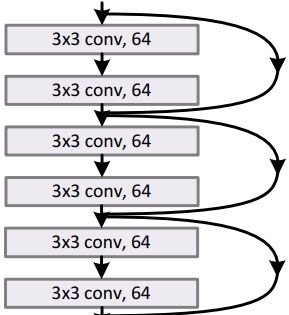

#### Every other layer (with channels increasing)
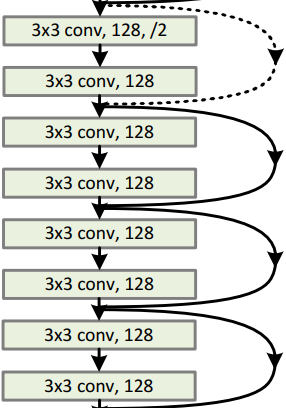

In [6]:
class ResNetLayer(nn.Module):
    """
    Implements ResNet layer
    The layer consists of multiple ResNet blocks
    """
    def __init__(self, in_channels, out_channels, layer_dim=2, first_downsample=False):
        super().__init__()
        self.layer = nn.Sequential()
        
        # Downsampling input to the current layer
        if first_downsample:
            self.layer.append(ResNetBlock(in_channels, out_channels, conv1_stride=2))

        # Adding the rest of the blocks to the layer
        for i in range(len(self.layer), layer_dim):
            self.layer.append(ResNetBlock(out_channels, out_channels))
            # print(in_channels, out_channels)

        # Excluding ReLU on the last block of the layer
        self.layer[-1].last_relu = False

    def forward(self, x):
        return self.layer(x)

## **3. Implementing ResNet model**

#### ResNet architecture for CIFAR10 dataset

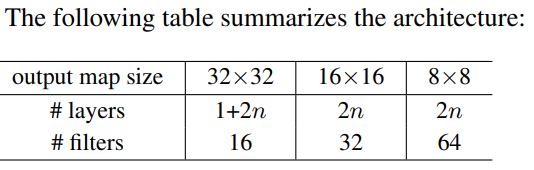

In [7]:
class ResNet(nn.Module):
    """
    Implements Residual Network (ResNet)
    The basic model for CIFAR10 dataset is resnet20
    
    'architecture' parameter is not yet used
    """
    def __init__(self, in_channels, num_classes = 10, architecture:int = 20, 
                 layer_dims:list = [3, 3, 3], initial_channels = 16):
        super().__init__()
        # self.num_classes = num_classes
        output_size = initial_channels * 2**(len(layer_dims)-1)
        self.fc_layer = nn.Linear(output_size, num_classes)
        
        # ---------- First convolution (and maxpool for ImageNet) ---------
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=initial_channels, 
                      kernel_size=3, stride=1, padding=1, bias=False),  # Change stride to 1 and padding to 3 if used on ImageNet
            nn.BatchNorm2d(initial_channels),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0),         # Uncomment if used on ImageNet
        )

        # ------------------------- ResNet layers -------------------------
        # Size of the first block of each layer: (16, 16)  -->  (16, 32)  -->  (32, 64)
        
        self.net.append(ResNetLayer(in_channels=initial_channels, out_channels=initial_channels, 
                                    layer_dim=layer_dims[0]))
        in_channels = initial_channels
        out_channels = in_channels * 2

        for dim in layer_dims[1:]:
            self.net.append(ResNetLayer(in_channels, out_channels, 
                                        layer_dim=dim, first_downsample=True))
            in_channels *= 2
            out_channels *= 2


    def forward(self, x):
        """
        Creates fully-connected layer (fc)
        """
        
        output = self.net(x)
        
        avg_pool = nn.AvgPool2d(kernel_size=output.shape[3])
        output = avg_pool(output)
        output = output.view(output.size(0), -1)
        # return output
        # output = output.flatten().unsqueeze(0)
        
        return self.fc_layer(output)

### Model output testing on a single image

In [8]:
# My model
model = ResNet(in_channels=3, num_classes=10, layer_dims=[3, 3, 3], initial_channels=16)
print(model)

ResNet(
  (fc_layer): Linear(in_features=64, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ResNetLayer(
      (layer): Sequential(
        (0): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv_1x1): Sequential()
        )
        (1): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

### Setting up the device for training

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
model = model.to(device)

## **4. Model training**
#### (run only once if you don't have previously saved model)

### 4.1.1 Single image dimensionality test

In [11]:
img_cifar10 = images[0].unsqueeze(0).to(device)
print(img_cifar10.shape)

torch.Size([1, 3, 32, 32])


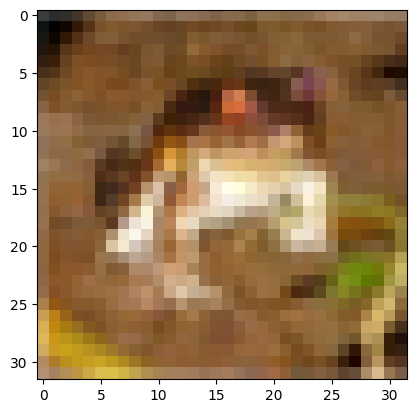

In [12]:
imshow(img_cifar10[0].cpu())

In [13]:
output = model(img_cifar10)

In [14]:
print(output.shape)

torch.Size([1, 10])


### 4.1.2 Multiple images dimensionality test

In [15]:
outputs = model(images.cuda())

In [16]:
print(outputs.shape)

torch.Size([128, 10])


### 4.2 Training loop

In [20]:
import torch.optim as optim

In [21]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
# Switching model to training mode
model.train()

n_epochs = 5
n_batches = len(train_loader)
epoch_loss = []

for epoch in tqdm.tqdm(range(n_epochs)):
    # Accumulated loss above all batches
    running_loss = 0.0
    
    for i, data in tqdm.tqdm(enumerate(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # switching to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # inputs = torch.nn.functional.interpolate(inputs, (227, 227))
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:    # print every 100 batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            # epoch_loss.append(running_loss / 100)
            running_loss = 0.0

    # Saving average loss above all batches
    epoch_loss.append(running_loss / n_batches)

# Switching model to evaluation mode
model.eval()

print('Finished Training')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
3it [00:01,  2.61it/s]
5it [00:01,  4.67it/s]
8it [00:01,  7.88it/s]
11it [00:01, 10.63it/s]
13it [00:01, 11.02it/s]
15it [00:02, 11.71it/s]
17it [00:02, 12.79it/s]
19it [00:02, 13.81it/s]
21it [00:02, 11.22it/s]
23it [00:02, 12.90it/s]
25it [00:02, 13.41it/s]
28it [00:02, 16.21it/s]
31it [00:03, 18.24it/s]
33it [00:03, 16.80it/s]
35it [00:03, 17.44it/s]
38it [00:03, 19.28it/s]
41it [00:03, 20.49it/s]
44it [00:03, 21.39it/s]
47it [00:03, 21.97it/s]
50it [00:04, 22.47it/s]
53it [00:04, 22.83it/s]
56it [00:04, 22.98it/s]
59it [00:04, 23.13it/s]
62it [00:04, 23.01it/s]
65it [00:04, 23.11it/s]
68it [00:04, 23.22it/s]
71it [00:04, 23.31it/s]
74it [00:05, 23.41it/s]
77it [00:05, 23.38it/s]
80it [00:05, 23.25it/s]
83it [00:05, 23.27it/s]
86it [00:05, 23.34it/s]
89it [00:05, 23.44it/s]
92it [00:05, 23.30it/s]
95it [00:05, 23.36it/s]
9

[1,   100] loss: 1.658



107it [00:06, 23.21it/s]
110it [00:06, 23.30it/s]
113it [00:06, 23.47it/s]
116it [00:06, 23.42it/s]
119it [00:06, 23.44it/s]
122it [00:07, 23.45it/s]
125it [00:07, 23.58it/s]
128it [00:07, 23.67it/s]
131it [00:07, 23.62it/s]
134it [00:07, 23.64it/s]
137it [00:07, 23.71it/s]
140it [00:07, 23.70it/s]
143it [00:07, 23.64it/s]
146it [00:08, 23.32it/s]
149it [00:08, 23.43it/s]
152it [00:08, 23.40it/s]
155it [00:08, 23.48it/s]
158it [00:08, 23.60it/s]
161it [00:08, 23.40it/s]
164it [00:08, 23.22it/s]
167it [00:09, 23.25it/s]
170it [00:09, 23.11it/s]
173it [00:09, 23.01it/s]
176it [00:09, 23.15it/s]
179it [00:09, 23.15it/s]
182it [00:09, 23.25it/s]
185it [00:09, 23.36it/s]
188it [00:09, 23.18it/s]
191it [00:10, 22.93it/s]
194it [00:10, 23.05it/s]
197it [00:10, 23.18it/s]
200it [00:10, 23.33it/s]
203it [00:10, 23.43it/s]

[1,   200] loss: 1.347



206it [00:10, 23.51it/s]
209it [00:10, 23.67it/s]
212it [00:10, 23.73it/s]
215it [00:11, 23.77it/s]
218it [00:11, 23.80it/s]
221it [00:11, 23.79it/s]
224it [00:11, 23.82it/s]
227it [00:11, 23.75it/s]
230it [00:11, 23.79it/s]
233it [00:11, 23.81it/s]
236it [00:11, 23.83it/s]
239it [00:12, 23.79it/s]
242it [00:12, 23.81it/s]
245it [00:12, 23.83it/s]
248it [00:12, 23.79it/s]
251it [00:12, 23.59it/s]
254it [00:12, 23.23it/s]
257it [00:12, 22.99it/s]
260it [00:12, 22.98it/s]
263it [00:13, 23.14it/s]
266it [00:13, 22.87it/s]
269it [00:13, 22.90it/s]
272it [00:13, 22.92it/s]
275it [00:13, 22.77it/s]
278it [00:13, 22.94it/s]
281it [00:13, 23.05it/s]
284it [00:14, 23.24it/s]
287it [00:14, 23.31it/s]
290it [00:14, 23.37it/s]
293it [00:14, 23.40it/s]
296it [00:14, 23.49it/s]
299it [00:14, 23.55it/s]
302it [00:14, 23.37it/s]

[1,   300] loss: 1.158



305it [00:14, 23.19it/s]
308it [00:15, 23.28it/s]
311it [00:15, 23.35it/s]
314it [00:15, 23.39it/s]
317it [00:15, 23.15it/s]
320it [00:15, 22.94it/s]
323it [00:15, 22.95it/s]
326it [00:15, 23.11it/s]
329it [00:15, 23.29it/s]
332it [00:16, 23.40it/s]
335it [00:16, 23.49it/s]
338it [00:16, 23.44it/s]
341it [00:16, 23.35it/s]
344it [00:16, 23.45it/s]
347it [00:16, 23.46it/s]
350it [00:16, 23.36it/s]
353it [00:16, 23.35it/s]
356it [00:17, 23.29it/s]
359it [00:17, 23.16it/s]
362it [00:17, 23.21it/s]
365it [00:17, 22.87it/s]
368it [00:17, 22.90it/s]
371it [00:17, 23.02it/s]
374it [00:17, 23.27it/s]
377it [00:18, 23.34it/s]
380it [00:18, 23.44it/s]
383it [00:18, 23.35it/s]
386it [00:18, 23.51it/s]
391it [00:19, 20.12it/s]
 20%|████████████████▊                                                                   | 1/5 [00:40<02:40, 40.14s/it]
0it [00:00, ?it/s]
1it [00:00,  4.23it/s]
3it [00:00,  9.57it/s]
5it [00:00, 13.00it/s]
8it [00:00, 16.39it/s]
11it [00:00, 18.58it/s]
14it [00:00, 20.24i

[2,   100] loss: 0.966



107it [00:04, 22.93it/s]
110it [00:05, 23.15it/s]
113it [00:05, 23.31it/s]
116it [00:05, 23.37it/s]
119it [00:05, 23.46it/s]
122it [00:05, 23.58it/s]
125it [00:05, 23.18it/s]
128it [00:05, 22.91it/s]
131it [00:05, 22.98it/s]
134it [00:06, 23.18it/s]
137it [00:06, 23.17it/s]
140it [00:06, 23.32it/s]
143it [00:06, 23.27it/s]
146it [00:06, 23.34it/s]
149it [00:06, 23.44it/s]
152it [00:06, 23.14it/s]
155it [00:06, 22.92it/s]
158it [00:07, 22.88it/s]
161it [00:07, 23.12it/s]
164it [00:07, 23.18it/s]
167it [00:07, 23.27it/s]
170it [00:07, 23.34it/s]
173it [00:07, 23.33it/s]
176it [00:07, 23.44it/s]
179it [00:07, 23.51it/s]
182it [00:08, 23.56it/s]
185it [00:08, 23.51it/s]
188it [00:08, 23.51it/s]
191it [00:08, 23.59it/s]
194it [00:08, 23.56it/s]
197it [00:08, 23.16it/s]
200it [00:08, 23.00it/s]
203it [00:09, 23.04it/s]

[2,   200] loss: 0.891



206it [00:09, 23.22it/s]
209it [00:09, 23.30it/s]
212it [00:09, 23.42it/s]
215it [00:09, 23.39it/s]
218it [00:09, 23.48it/s]
221it [00:09, 23.48it/s]
224it [00:09, 23.22it/s]
227it [00:10, 23.03it/s]
230it [00:10, 23.12it/s]
233it [00:10, 23.18it/s]
236it [00:10, 23.22it/s]
239it [00:10, 23.30it/s]
242it [00:10, 23.36it/s]
245it [00:10, 23.35it/s]
248it [00:10, 23.02it/s]
251it [00:11, 22.95it/s]
254it [00:11, 22.69it/s]
257it [00:11, 22.67it/s]
260it [00:11, 22.55it/s]
263it [00:11, 22.78it/s]
266it [00:11, 22.99it/s]
269it [00:11, 23.19it/s]
272it [00:12, 23.07it/s]
275it [00:12, 22.88it/s]
278it [00:12, 22.91it/s]
281it [00:12, 22.66it/s]
284it [00:12, 20.90it/s]
287it [00:12, 20.18it/s]
290it [00:12, 19.79it/s]
292it [00:13, 19.67it/s]
294it [00:13, 19.53it/s]
296it [00:13, 19.38it/s]
298it [00:13, 19.25it/s]
300it [00:13, 19.42it/s]
303it [00:13, 20.60it/s]

[2,   300] loss: 0.863



306it [00:13, 21.42it/s]
309it [00:13, 21.85it/s]
312it [00:13, 22.25it/s]
315it [00:14, 22.57it/s]
318it [00:14, 22.85it/s]
321it [00:14, 22.73it/s]
324it [00:14, 22.58it/s]
327it [00:14, 22.54it/s]
330it [00:14, 22.93it/s]
333it [00:14, 22.58it/s]
336it [00:14, 22.59it/s]
339it [00:15, 22.80it/s]
342it [00:15, 22.96it/s]
345it [00:15, 23.11it/s]
348it [00:15, 23.23it/s]
351it [00:15, 23.42it/s]
354it [00:15, 23.45it/s]
357it [00:15, 22.72it/s]
360it [00:16, 23.00it/s]
363it [00:16, 23.25it/s]
366it [00:16, 23.44it/s]
369it [00:16, 23.51it/s]
372it [00:16, 23.56it/s]
375it [00:16, 23.60it/s]
378it [00:16, 23.57it/s]
381it [00:16, 23.44it/s]
384it [00:17, 23.24it/s]
387it [00:17, 23.10it/s]
391it [00:18, 20.83it/s]
 40%|█████████████████████████████████▌                                                  | 2/5 [01:12<01:46, 35.60s/it]
0it [00:00, ?it/s]
3it [00:00, 22.96it/s]
6it [00:00, 23.27it/s]
9it [00:00, 23.21it/s]
12it [00:00, 23.26it/s]
15it [00:00, 23.28it/s]
18it [00:00, 23.35

[3,   100] loss: 0.740



105it [00:04, 22.84it/s]
108it [00:04, 23.19it/s]
111it [00:04, 23.02it/s]
114it [00:04, 22.89it/s]
117it [00:05, 23.07it/s]
120it [00:05, 22.93it/s]
123it [00:05, 22.94it/s]
126it [00:05, 23.21it/s]
129it [00:05, 23.41it/s]
132it [00:05, 23.38it/s]
135it [00:05, 23.13it/s]
138it [00:06, 23.35it/s]
141it [00:06, 23.50it/s]
144it [00:06, 23.61it/s]
147it [00:06, 23.69it/s]
150it [00:06, 23.80it/s]
153it [00:06, 23.82it/s]
156it [00:06, 23.84it/s]
159it [00:06, 23.79it/s]
162it [00:07, 23.82it/s]
165it [00:07, 23.83it/s]
168it [00:07, 23.85it/s]
171it [00:07, 23.74it/s]
174it [00:07, 23.61it/s]
177it [00:07, 23.69it/s]
180it [00:07, 23.63it/s]
183it [00:07, 23.65it/s]
186it [00:08, 23.49it/s]
189it [00:08, 23.28it/s]
192it [00:08, 23.13it/s]
195it [00:08, 23.03it/s]
198it [00:08, 22.49it/s]
201it [00:08, 22.78it/s]
204it [00:08, 22.99it/s]

[3,   200] loss: 0.699



207it [00:08, 23.09it/s]
210it [00:09, 22.89it/s]
213it [00:09, 22.71it/s]
216it [00:09, 22.63it/s]
219it [00:09, 22.63it/s]
222it [00:09, 22.62it/s]
225it [00:09, 22.93it/s]
228it [00:09, 22.73it/s]
231it [00:10, 22.64it/s]
234it [00:10, 22.90it/s]
237it [00:10, 23.07it/s]
240it [00:10, 23.25it/s]
243it [00:10, 23.38it/s]
246it [00:10, 23.36it/s]
249it [00:10, 23.46it/s]
252it [00:10, 23.47it/s]
255it [00:11, 23.54it/s]
258it [00:11, 23.47it/s]
261it [00:11, 23.48it/s]
264it [00:11, 23.54it/s]
267it [00:11, 23.47it/s]
270it [00:11, 23.16it/s]
273it [00:11, 23.26it/s]
276it [00:11, 23.38it/s]
279it [00:12, 23.15it/s]
282it [00:12, 23.09it/s]
285it [00:12, 22.84it/s]
288it [00:12, 22.88it/s]
291it [00:12, 23.11it/s]
294it [00:12, 23.28it/s]
297it [00:12, 23.29it/s]
300it [00:12, 23.09it/s]
303it [00:13, 23.00it/s]

[3,   300] loss: 0.705



306it [00:13, 23.15it/s]
309it [00:13, 23.25it/s]
312it [00:13, 23.22it/s]
315it [00:13, 22.98it/s]
318it [00:13, 23.08it/s]
321it [00:13, 22.84it/s]
324it [00:14, 23.02it/s]
327it [00:14, 23.16it/s]
330it [00:14, 23.00it/s]
333it [00:14, 22.83it/s]
336it [00:14, 23.03it/s]
339it [00:14, 23.17it/s]
342it [00:14, 23.37it/s]
345it [00:14, 23.47it/s]
348it [00:15, 23.15it/s]
351it [00:15, 22.94it/s]
354it [00:15, 23.10it/s]
357it [00:15, 23.22it/s]
360it [00:15, 23.36it/s]
363it [00:15, 23.40it/s]
366it [00:15, 23.48it/s]
369it [00:15, 23.55it/s]
372it [00:16, 23.48it/s]
375it [00:16, 23.54it/s]
378it [00:16, 23.58it/s]
381it [00:16, 23.56it/s]
384it [00:16, 23.21it/s]
387it [00:16, 22.98it/s]
391it [00:17, 22.05it/s]
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:07, 33.93s/it]
0it [00:00, ?it/s]
1it [00:00,  4.54it/s]
3it [00:00, 10.04it/s]
6it [00:00, 14.69it/s]
9it [00:00, 17.28it/s]
12it [00:00, 19.04it/s]
15it [00:00, 20.25i

[4,   100] loss: 0.596



105it [00:04, 23.34it/s]
108it [00:04, 23.44it/s]
111it [00:05, 23.52it/s]
114it [00:05, 23.57it/s]
117it [00:05, 23.55it/s]
120it [00:05, 23.37it/s]
123it [00:05, 23.09it/s]
126it [00:05, 22.89it/s]
129it [00:05, 23.12it/s]
132it [00:05, 23.23it/s]
135it [00:06, 23.21it/s]
138it [00:06, 22.97it/s]
141it [00:06, 22.97it/s]
144it [00:06, 22.76it/s]
147it [00:06, 22.98it/s]
150it [00:06, 23.13it/s]
153it [00:06, 23.08it/s]
156it [00:06, 22.89it/s]
159it [00:07, 22.70it/s]
162it [00:07, 22.88it/s]
165it [00:07, 23.07it/s]
168it [00:07, 23.14it/s]
171it [00:07, 23.30it/s]
174it [00:07, 23.36it/s]
177it [00:07, 23.40it/s]
180it [00:08, 23.40it/s]
183it [00:08, 23.43it/s]
186it [00:08, 23.45it/s]
189it [00:08, 23.46it/s]
192it [00:08, 23.53it/s]
195it [00:08, 23.58it/s]
198it [00:08, 23.55it/s]
201it [00:08, 23.43it/s]
204it [00:09, 23.51it/s]

[4,   200] loss: 0.608



207it [00:09, 23.39it/s]
210it [00:09, 23.53it/s]
213it [00:09, 23.53it/s]
216it [00:09, 23.58it/s]
219it [00:09, 23.28it/s]
222it [00:09, 22.97it/s]
225it [00:09, 22.81it/s]
228it [00:10, 23.12it/s]
231it [00:10, 23.23it/s]
234it [00:10, 23.37it/s]
237it [00:10, 23.11it/s]
240it [00:10, 23.06it/s]
243it [00:10, 23.22it/s]
246it [00:10, 23.42it/s]
249it [00:10, 23.50it/s]
252it [00:11, 23.20it/s]
255it [00:11, 23.13it/s]
258it [00:11, 23.24it/s]
261it [00:11, 23.00it/s]
264it [00:11, 23.04it/s]
267it [00:11, 23.17it/s]
270it [00:11, 23.06it/s]
273it [00:12, 22.87it/s]
276it [00:12, 22.90it/s]
279it [00:12, 23.13it/s]
282it [00:12, 23.29it/s]
285it [00:12, 23.35it/s]
288it [00:12, 23.40it/s]
291it [00:12, 23.43it/s]
294it [00:12, 23.61it/s]
297it [00:13, 23.64it/s]
300it [00:13, 23.65it/s]
303it [00:13, 23.55it/s]

[4,   300] loss: 0.615



306it [00:13, 23.59it/s]
309it [00:13, 23.62it/s]
312it [00:13, 23.53it/s]
315it [00:13, 23.57it/s]
318it [00:13, 23.67it/s]
321it [00:14, 23.61it/s]
324it [00:14, 23.47it/s]
327it [00:14, 23.48it/s]
330it [00:14, 23.54it/s]
333it [00:14, 23.53it/s]
336it [00:14, 23.63it/s]
339it [00:14, 23.59it/s]
342it [00:14, 23.24it/s]
345it [00:15, 23.00it/s]
348it [00:15, 23.20it/s]
351it [00:15, 23.29it/s]
354it [00:15, 23.40it/s]
357it [00:15, 23.38it/s]
360it [00:15, 23.42it/s]
363it [00:15, 23.44it/s]
366it [00:15, 23.51it/s]
369it [00:16, 23.57it/s]
372it [00:16, 23.66it/s]
375it [00:16, 23.55it/s]
378it [00:16, 23.54it/s]
381it [00:16, 23.53it/s]
384it [00:16, 23.41it/s]
387it [00:16, 23.44it/s]
391it [00:17, 21.95it/s]
 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:33, 33.05s/it]
0it [00:00, ?it/s]
2it [00:00, 19.66it/s]
5it [00:00, 21.79it/s]
8it [00:00, 22.69it/s]
11it [00:00, 23.02it/s]
14it [00:00, 23.26it/s]
17it [00:00, 23.34

[5,   100] loss: 0.512



107it [00:04, 23.30it/s]
110it [00:04, 23.41it/s]
113it [00:04, 23.44it/s]
116it [00:04, 23.51it/s]
119it [00:05, 23.51it/s]
122it [00:05, 23.62it/s]
125it [00:05, 23.36it/s]
128it [00:05, 23.08it/s]
131it [00:05, 23.10it/s]
134it [00:05, 23.27it/s]
137it [00:05, 23.34it/s]
140it [00:06, 23.33it/s]
143it [00:06, 23.06it/s]
146it [00:06, 23.08it/s]
149it [00:06, 22.89it/s]
152it [00:06, 23.11it/s]
155it [00:06, 23.28it/s]
158it [00:06, 23.03it/s]
161it [00:06, 23.11it/s]
164it [00:07, 23.33it/s]
167it [00:07, 23.12it/s]
170it [00:07, 22.96it/s]
173it [00:07, 22.96it/s]
176it [00:07, 22.91it/s]
179it [00:07, 23.09it/s]
182it [00:07, 23.05it/s]
185it [00:07, 22.86it/s]
188it [00:08, 22.79it/s]
191it [00:08, 23.00it/s]
194it [00:08, 23.15it/s]
197it [00:08, 23.25it/s]
200it [00:08, 23.33it/s]
203it [00:08, 23.49it/s]

[5,   200] loss: 0.521



206it [00:08, 23.44it/s]
209it [00:09, 23.51it/s]
212it [00:09, 23.51it/s]
215it [00:09, 23.56it/s]
218it [00:09, 23.43it/s]
221it [00:09, 23.44it/s]
224it [00:09, 23.46it/s]
227it [00:09, 23.20it/s]
230it [00:09, 23.02it/s]
233it [00:10, 23.16it/s]
236it [00:10, 23.21it/s]
239it [00:10, 23.30it/s]
242it [00:10, 23.30it/s]
245it [00:10, 23.36it/s]
248it [00:10, 23.40it/s]
251it [00:10, 23.32it/s]
254it [00:10, 23.37it/s]
257it [00:11, 23.41it/s]
260it [00:11, 23.38it/s]
263it [00:11, 23.37it/s]
266it [00:11, 23.35it/s]
269it [00:11, 23.34it/s]
272it [00:11, 23.39it/s]
275it [00:11, 23.37it/s]
278it [00:11, 23.41it/s]
281it [00:12, 23.41it/s]
284it [00:12, 23.38it/s]
287it [00:12, 23.36it/s]
290it [00:12, 23.40it/s]
293it [00:12, 23.38it/s]
296it [00:12, 23.09it/s]
299it [00:12, 22.89it/s]
302it [00:12, 23.14it/s]

[5,   300] loss: 0.514



305it [00:13, 23.19it/s]
308it [00:13, 23.34it/s]
311it [00:13, 23.33it/s]
314it [00:13, 23.11it/s]
317it [00:13, 22.96it/s]
320it [00:13, 23.12it/s]
323it [00:13, 23.23it/s]
326it [00:14, 23.20it/s]
329it [00:14, 22.92it/s]
332it [00:14, 22.98it/s]
335it [00:14, 23.08it/s]
338it [00:14, 23.26it/s]
341it [00:14, 23.01it/s]
344it [00:14, 22.89it/s]
347it [00:14, 23.07it/s]
350it [00:15, 23.14it/s]
353it [00:15, 23.20it/s]
356it [00:15, 23.28it/s]
359it [00:15, 23.30it/s]
362it [00:15, 23.41it/s]
365it [00:15, 23.38it/s]
368it [00:15, 23.42it/s]
371it [00:15, 23.44it/s]
374it [00:16, 23.40it/s]
377it [00:16, 23.43it/s]
380it [00:16, 23.51it/s]
383it [00:16, 23.29it/s]
386it [00:16, 23.41it/s]
391it [00:17, 22.30it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.37s/it]

Finished Training


#### Saving model for further usage

In [23]:
# model.state_dict()

In [24]:
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
torch.save(model.cpu().state_dict(), path+'my_resnet20')

#### Loss plot

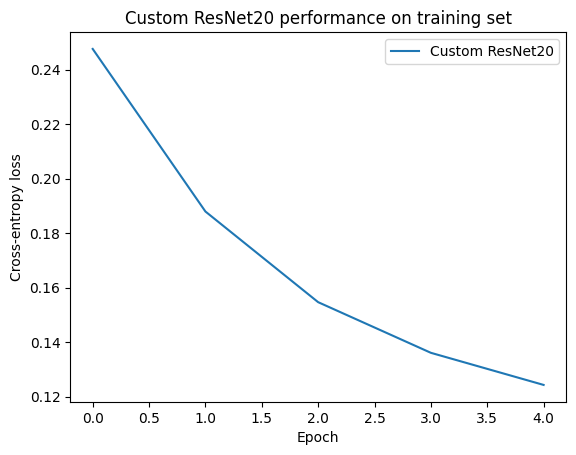

In [25]:
plt.plot(epoch_loss, label='Custom ResNet20')
plt.legend()
plt.title('Custom ResNet20 performance on training set')
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.show()

## **5 Model evaluation**

#### Loading pretrained model

In [11]:
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
model.load_state_dict(torch.load(path+'my_resnet20'))
model = model.to(device)
model.eval()

ResNet(
  (fc_layer): Linear(in_features=64, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ResNetLayer(
      (layer): Sequential(
        (0): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv_1x1): Sequential()
        )
        (1): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

### 5.1 Single image prediction test

In [12]:
# get some random test images
dataiter = iter(test_loader)
test_images, test_labels = next(dataiter)

# switching to GPU
test_images = test_images.to(device)
test_labels = test_labels.to(device)

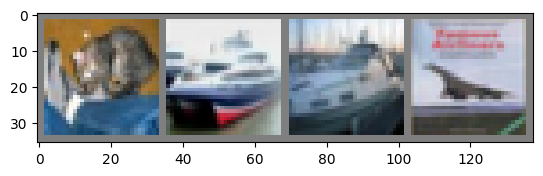

cat   ship  ship  plane


In [13]:
# starting and stopping indeces to slice 4 images
start = 0
stop = start + 4

# show images
imshow(torchvision.utils.make_grid(test_images[start:stop].cpu()))
# print labels
print(' '.join(f'{classes[test_labels[j]]:5s}' for j in range(start, stop)))

In [14]:
# Indeces of each class
for i in range(len(classes)):
    print(f'class {i} - {classes[i]}')

class 0 - plane
class 1 - car
class 2 - bird
class 3 - cat
class 4 - deer
class 5 - dog
class 6 - frog
class 7 - horse
class 8 - ship
class 9 - truck


In [15]:
def class_probabilities(predictions, classes):
    """
    Prints class probabilities sorted in descending order 
    """
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy() if predictions.get_device() != -1 else predictions.numpy()
    
    for class_probs in predictions:
        sorted_predictions = pd.DataFrame()
        sorted_predictions.index.name = 'class_index'
        sorted_predictions['class_label'] = classes
        sorted_predictions['class_probabilities'] = class_probs
        sorted_predictions = sorted_predictions.sort_values('class_probabilities', ascending=False)
        print(sorted_predictions, "\n")

#### Softmax activation

In [16]:
test_image = test_images[start+3].unsqueeze(0)

predictions = model(test_image).softmax(dim=1).cpu().detach().numpy()

predicted_class = predictions[0].argmax()
print(f'Predicted class: {predicted_class} - {classes[predicted_class]}\n')

class_probabilities(predictions, classes)

Predicted class: 0 - plane

            class_label  class_probabilities
class_index                                 
0                 plane             0.789511
8                  ship             0.095232
4                  deer             0.040665
2                  bird             0.034944
3                   cat             0.020980
9                 truck             0.005818
1                   car             0.005576
7                 horse             0.003710
5                   dog             0.002147
6                  frog             0.001415 



#### Sigmoid activation

In [18]:
predictions = model(test_image).sigmoid().cpu().detach().numpy()

predicted_class = predictions[0].argmax()
print(f'Predicted class: {predicted_class} - {classes[predicted_class]}\n')

class_probabilities(predictions, classes)

Predicted class: 0 - plane

            class_label  class_probabilities
class_index                                 
0                 plane             0.902898
8                  ship             0.528657
4                  deer             0.323837
2                  bird             0.291562
3                   cat             0.198136
9                 truck             0.064130
1                   car             0.061625
7                 horse             0.041863
5                   dog             0.024667
6                  frog             0.016394 



### 5.2 Multiple image prediction test

In [19]:
predictions = model(test_images[start:stop]).softmax(dim=1).detach()
# print(f'Class probabilities:\n{predictions}\n')

classes_np = np.array(classes)
predicted_classes = predictions.argmax(dim=1)
print(f'Predicted classes: {predicted_classes} - {classes_np[predicted_classes.cpu()]}')
print(f'True classes: {test_labels[start:stop]} - {classes_np[test_labels[start:stop].cpu()]}\n')

class_probabilities(predictions, classes)

Predicted classes: tensor([3, 8, 8, 0], device='cuda:0') - ['cat' 'ship' 'ship' 'plane']
True classes: tensor([3, 8, 8, 0], device='cuda:0') - ['cat' 'ship' 'ship' 'plane']

            class_label  class_probabilities
class_index                                 
3                   cat             0.921001
5                   dog             0.067660
6                  frog             0.009419
4                  deer             0.001085
2                  bird             0.000218
0                 plane             0.000210
7                 horse             0.000154
8                  ship             0.000147
1                   car             0.000085
9                 truck             0.000020 

            class_label  class_probabilities
class_index                                 
8                  ship             0.982304
1                   car             0.015700
0                 plane             0.001792
9                 truck             0.000096
3             

### 5.3 Prediction accuracy test

In [20]:
def accuracy_score_table(prediction_accuracy, classes):
    if isinstance(prediction_accuracy, torch.Tensor):
        if prediction_accuracy.get_device() != -1:
            prediction_accuracy = prediction_accuracy.cpu().numpy()
        else: 
            prediction_accuracy = prediction_accuracy.numpy()
    
        accuracy_table = pd.DataFrame()
        accuracy_table.index.name = 'class_index'
        accuracy_table['class_label'] = classes
        accuracy_table['prediction_accuracy'] = prediction_accuracy
        # print(accuracy_table, "\n")
        return accuracy_table
    
    print('Input is not a torch.Tensor')
    return None


In [21]:
def accuracy_score(class_probs, labels, n_classes):
    predictions = class_probs.argmax(dim=1)
    class_idx = np.arange(n_classes)
    
    accuracy = [0 for c in class_idx]
    for c in class_idx:
        accuracy[c] = ((predictions == labels) * (labels == c)).float().sum() / max((labels == c).sum(), 1)
    
    device = class_probs.get_device()
    return torch.Tensor(accuracy).to(device='cuda')

In [25]:
def evaluate(test_loader, model, n_classes=10, to_size=None, print_accuracy=False):
    """
    Calculates model's accuracy score for each batch in test_loader
    """
    # Switching model to evaluation mode
    model.eval()

    # Choosing metric
    metric = accuracy_score

    # Accuracy on the whole test set
    total_accuracy = torch.Tensor([0]*n_classes).to(device='cuda')

    n_batches = len(test_loader)
    
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # Getting batch data
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
    
            # Class probabilities
            if to_size:
                images = torch.nn.functional.interpolate(images, (to_size, to_size))
            class_probs = model(images).softmax(dim=1).detach()
            
            # Accuracy score
            accuracy = metric(class_probs, labels, n_classes)

            if print_accuracy:
                print(accuracy_score_table(accuracy, classes))

            total_accuracy += accuracy

    total_accuracy /= n_batches
    return total_accuracy

In [26]:
total_accuracy = evaluate(test_loader, model, n_classes=10, print_accuracy=True)

            class_label  prediction_accuracy
class_index                                 
0                 plane             0.846154
1                   car             0.900000
2                  bird             0.545455
3                   cat             0.866667
4                  deer             0.800000
5                   dog             0.666667
6                  frog             0.842105
7                 horse             0.538462
8                  ship             1.000000
9                 truck             0.909091
            class_label  prediction_accuracy
class_index                                 
0                 plane             0.923077
1                   car             1.000000
2                  bird             0.307692
3                   cat             1.000000
4                  deer             0.900000
5                   dog             0.705882
6                  frog             0.800000
7                 horse             0.727273
8         

In [27]:
resnet20_class_accuracy = accuracy_score_table(total_accuracy, classes)
print(resnet20_class_accuracy)

            class_label  prediction_accuracy
class_index                                 
0                 plane             0.799533
1                   car             0.859570
2                  bird             0.453546
3                   cat             0.719712
4                  deer             0.831786
5                   dog             0.667584
6                  frog             0.866976
7                 horse             0.687833
8                  ship             0.808326
9                 truck             0.761706


## **6. Comparing my model to _timm_ ResNet**
https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/resnet.py

In [269]:
# %pip install timm

     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     ---------------------------------------- 43.6/43.6 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.3 MB 4.1 MB/s eta 0:00:01
   ----- ---------------------------------- 0.3/2.3 MB 4.2 MB/s eta 0:00:01
   ------------ --------------------------- 0.7/2.3 MB 5.0 MB/s eta 0:00:01
   ---------------------- ----------------- 1.3/2.3 MB 6.7 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------  2.3/2.3 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 7.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/401.3 kB ? eta -:--:--
   --------------------------------------  399.4/401.3 kB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 401.3/401.3 kB 8.3 MB/s eta 0:00:00
   -------------

In [28]:
import timm
from timm.models.resnet import resnet18

D:\DataScience\ONU\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 6.1 Importing resnet18 pretrained on ImageNet

In [29]:
timm_model = resnet18(pretrained=True, num_classes=10)
timm_model = timm_model.to(device)
print(timm_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

### 6.2 Training _timm_ resnet18 on cifar10 train set

In [101]:
import torch.optim as optim

In [102]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(timm_model.parameters(), lr=learning_rate)

In [103]:
# Switching model to training mode
timm_model.train()

n_epochs = 5
n_batches = len(train_loader)
epoch_loss = []

for epoch in tqdm.tqdm(range(n_epochs)):
    # Accumulated loss above all batches
    running_loss = 0.0
    
    for i, data in tqdm.tqdm(enumerate(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # switching to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # data upsampling
        inputs_resized = torch.nn.functional.interpolate(inputs, (224, 224))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = timm_model(inputs_resized)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:    # print every 100 batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            # epoch_loss.append(running_loss / 100)
            running_loss = 0.0

    # Saving average loss above all batches
    epoch_loss.append(running_loss / n_batches)

# Switching model to evaluation mode
timm_model.eval()

print('Finished Training')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.09it/s]
2it [00:01,  1.50it/s]
3it [00:01,  1.73it/s]
4it [00:02,  1.84it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.97it/s]
7it [00:03,  2.01it/s]
8it [00:04,  2.04it/s]
9it [00:04,  2.06it/s]
10it [00:05,  2.07it/s]
11it [00:05,  2.09it/s]
12it [00:06,  2.10it/s]
13it [00:06,  2.10it/s]
14it [00:07,  2.10it/s]
15it [00:07,  2.10it/s]
16it [00:08,  2.11it/s]
17it [00:08,  2.11it/s]
18it [00:09,  2.11it/s]
19it [00:09,  2.11it/s]
20it [00:09,  2.11it/s]
21it [00:10,  2.10it/s]
22it [00:10,  2.09it/s]
23it [00:11,  2.08it/s]
24it [00:11,  2.10it/s]
25it [00:12,  2.11it/s]
26it [00:12,  2.10it/s]
27it [00:13,  2.11it/s]
28it [00:13,  2.09it/s]
29it [00:14,  2.08it/s]
30it [00:14,  2.08it/s]
31it [00:15,  2.07it/s]
32it [00:15,  2.06it/s]
33it [00:16,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:17,  2.06it/s]
36it [00:17,  2.08it/s]
37it [

[1,   100] loss: 0.956



101it [00:48,  2.11it/s]
102it [00:49,  2.12it/s]
103it [00:49,  2.11it/s]
104it [00:50,  2.12it/s]
105it [00:50,  2.11it/s]
106it [00:51,  2.11it/s]
107it [00:51,  2.11it/s]
108it [00:51,  2.11it/s]
109it [00:52,  2.11it/s]
110it [00:52,  2.11it/s]
111it [00:53,  2.11it/s]
112it [00:53,  2.12it/s]
113it [00:54,  2.12it/s]
114it [00:54,  2.12it/s]
115it [00:55,  2.12it/s]
116it [00:55,  2.11it/s]
117it [00:56,  2.11it/s]
118it [00:56,  2.12it/s]
119it [00:57,  2.12it/s]
120it [00:57,  2.12it/s]
121it [00:58,  2.11it/s]
122it [00:58,  2.11it/s]
123it [00:59,  2.11it/s]
124it [00:59,  2.12it/s]
125it [01:00,  2.12it/s]
126it [01:00,  2.13it/s]
127it [01:00,  2.12it/s]
128it [01:01,  2.11it/s]
129it [01:01,  2.12it/s]
130it [01:02,  2.12it/s]
131it [01:02,  2.12it/s]
132it [01:03,  2.12it/s]
133it [01:03,  2.12it/s]
134it [01:04,  2.12it/s]
135it [01:04,  2.12it/s]
136it [01:05,  2.13it/s]
137it [01:05,  2.12it/s]
138it [01:06,  2.12it/s]
139it [01:06,  2.11it/s]
140it [01:07,  2.11it/s]

[1,   200] loss: 0.344



201it [01:36,  2.04it/s]
202it [01:37,  2.04it/s]
203it [01:37,  2.05it/s]
204it [01:38,  2.05it/s]
205it [01:38,  2.04it/s]
206it [01:39,  2.05it/s]
207it [01:39,  2.05it/s]
208it [01:39,  2.05it/s]
209it [01:40,  2.06it/s]
210it [01:40,  2.08it/s]
211it [01:41,  2.08it/s]
212it [01:41,  2.07it/s]
213it [01:42,  2.06it/s]
214it [01:42,  2.06it/s]
215it [01:43,  2.06it/s]
216it [01:43,  2.07it/s]
217it [01:44,  2.09it/s]
218it [01:44,  2.10it/s]
219it [01:45,  2.10it/s]
220it [01:45,  2.10it/s]
221it [01:46,  2.10it/s]
222it [01:46,  2.11it/s]
223it [01:47,  2.12it/s]
224it [01:47,  2.12it/s]
225it [01:48,  2.13it/s]
226it [01:48,  2.13it/s]
227it [01:49,  2.13it/s]
228it [01:49,  2.13it/s]
229it [01:49,  2.13it/s]
230it [01:50,  2.12it/s]
231it [01:50,  2.12it/s]
232it [01:51,  2.12it/s]
233it [01:51,  2.12it/s]
234it [01:52,  2.12it/s]
235it [01:52,  2.12it/s]
236it [01:53,  2.11it/s]
237it [01:53,  2.10it/s]
238it [01:54,  2.09it/s]
239it [01:54,  2.09it/s]
240it [01:55,  2.10it/s]

[1,   300] loss: 0.266



301it [02:23,  2.13it/s]
302it [02:24,  2.13it/s]
303it [02:24,  2.13it/s]
304it [02:25,  2.13it/s]
305it [02:25,  2.13it/s]
306it [02:26,  2.13it/s]
307it [02:26,  2.13it/s]
308it [02:27,  2.13it/s]
309it [02:27,  2.13it/s]
310it [02:28,  2.13it/s]
311it [02:28,  2.13it/s]
312it [02:29,  2.13it/s]
313it [02:29,  2.13it/s]
314it [02:29,  2.13it/s]
315it [02:30,  2.13it/s]
316it [02:30,  2.13it/s]
317it [02:31,  2.13it/s]
318it [02:31,  2.12it/s]
319it [02:32,  2.11it/s]
320it [02:32,  2.11it/s]
321it [02:33,  2.11it/s]
322it [02:33,  2.10it/s]
323it [02:34,  2.10it/s]
324it [02:34,  2.10it/s]
325it [02:35,  2.10it/s]
326it [02:35,  2.10it/s]
327it [02:36,  2.10it/s]
328it [02:36,  2.10it/s]
329it [02:37,  2.10it/s]
330it [02:37,  2.10it/s]
331it [02:38,  2.10it/s]
332it [02:38,  2.10it/s]
333it [02:38,  2.10it/s]
334it [02:39,  2.10it/s]
335it [02:39,  2.10it/s]
336it [02:40,  2.10it/s]
337it [02:40,  2.10it/s]
338it [02:41,  2.10it/s]
339it [02:41,  2.10it/s]
340it [02:42,  2.10it/s]

[2,   100] loss: 0.182



101it [00:47,  2.13it/s]
102it [00:48,  2.13it/s]
103it [00:48,  2.13it/s]
104it [00:49,  2.13it/s]
105it [00:49,  2.13it/s]
106it [00:49,  2.13it/s]
107it [00:50,  2.13it/s]
108it [00:50,  2.13it/s]
109it [00:51,  2.13it/s]
110it [00:51,  2.13it/s]
111it [00:52,  2.13it/s]
112it [00:52,  2.13it/s]
113it [00:53,  2.13it/s]
114it [00:53,  2.13it/s]
115it [00:54,  2.13it/s]
116it [00:54,  2.13it/s]
117it [00:55,  2.13it/s]
118it [00:55,  2.13it/s]
119it [00:56,  2.13it/s]
120it [00:56,  2.13it/s]
121it [00:57,  2.13it/s]
122it [00:57,  2.13it/s]
123it [00:57,  2.12it/s]
124it [00:58,  2.13it/s]
125it [00:58,  2.12it/s]
126it [00:59,  2.12it/s]
127it [00:59,  2.12it/s]
128it [01:00,  2.12it/s]
129it [01:00,  2.12it/s]
130it [01:01,  2.12it/s]
131it [01:01,  2.12it/s]
132it [01:02,  2.12it/s]
133it [01:02,  2.12it/s]
134it [01:03,  2.12it/s]
135it [01:03,  2.12it/s]
136it [01:04,  2.12it/s]
137it [01:04,  2.12it/s]
138it [01:05,  2.12it/s]
139it [01:05,  2.12it/s]
140it [01:05,  2.13it/s]

[2,   200] loss: 0.122



201it [01:34,  2.12it/s]
202it [01:35,  2.12it/s]
203it [01:35,  2.12it/s]
204it [01:36,  2.12it/s]
205it [01:36,  2.12it/s]
206it [01:37,  2.12it/s]
207it [01:37,  2.12it/s]
208it [01:38,  2.12it/s]
209it [01:38,  2.12it/s]
210it [01:38,  2.13it/s]
211it [01:39,  2.12it/s]
212it [01:39,  2.12it/s]
213it [01:40,  2.12it/s]
214it [01:40,  2.12it/s]
215it [01:41,  2.12it/s]
216it [01:41,  2.13it/s]
217it [01:42,  2.12it/s]
218it [01:42,  2.12it/s]
219it [01:43,  2.12it/s]
220it [01:43,  2.12it/s]
221it [01:44,  2.12it/s]
222it [01:44,  2.12it/s]
223it [01:45,  2.12it/s]
224it [01:45,  2.12it/s]
225it [01:46,  2.12it/s]
226it [01:46,  2.12it/s]
227it [01:46,  2.12it/s]
228it [01:47,  2.12it/s]
229it [01:47,  2.12it/s]
230it [01:48,  2.12it/s]
231it [01:48,  2.12it/s]
232it [01:49,  2.12it/s]
233it [01:49,  2.12it/s]
234it [01:50,  2.12it/s]
235it [01:50,  2.12it/s]
236it [01:51,  2.12it/s]
237it [01:51,  2.12it/s]
238it [01:52,  2.13it/s]
239it [01:52,  2.12it/s]
240it [01:53,  2.12it/s]

[2,   300] loss: 0.097



301it [02:21,  2.12it/s]
302it [02:22,  2.12it/s]
303it [02:22,  2.12it/s]
304it [02:23,  2.12it/s]
305it [02:23,  2.12it/s]
306it [02:24,  2.12it/s]
307it [02:24,  2.12it/s]
308it [02:25,  2.12it/s]
309it [02:25,  2.12it/s]
310it [02:26,  2.12it/s]
311it [02:26,  2.12it/s]
312it [02:27,  2.12it/s]
313it [02:27,  2.12it/s]
314it [02:27,  2.12it/s]
315it [02:28,  2.12it/s]
316it [02:28,  2.12it/s]
317it [02:29,  2.12it/s]
318it [02:29,  2.12it/s]
319it [02:30,  2.12it/s]
320it [02:30,  2.12it/s]
321it [02:31,  2.12it/s]
322it [02:31,  2.12it/s]
323it [02:32,  2.12it/s]
324it [02:32,  2.12it/s]
325it [02:33,  2.12it/s]
326it [02:33,  2.12it/s]
327it [02:34,  2.12it/s]
328it [02:34,  2.12it/s]
329it [02:35,  2.12it/s]
330it [02:35,  2.12it/s]
331it [02:35,  2.12it/s]
332it [02:36,  2.12it/s]
333it [02:36,  2.12it/s]
334it [02:37,  2.13it/s]
335it [02:37,  2.13it/s]
336it [02:38,  2.12it/s]
337it [02:38,  2.12it/s]
338it [02:39,  2.12it/s]
339it [02:39,  2.12it/s]
340it [02:40,  2.12it/s]

[3,   100] loss: 0.064



101it [00:48,  2.08it/s]
102it [00:49,  2.07it/s]
103it [00:49,  2.07it/s]
104it [00:50,  2.07it/s]
105it [00:50,  2.07it/s]
106it [00:51,  2.07it/s]
107it [00:51,  2.07it/s]
108it [00:52,  2.08it/s]
109it [00:52,  2.10it/s]
110it [00:53,  2.10it/s]
111it [00:53,  2.11it/s]
112it [00:54,  2.11it/s]
113it [00:54,  2.11it/s]
114it [00:55,  2.11it/s]
115it [00:55,  2.12it/s]
116it [00:56,  2.10it/s]
117it [00:56,  2.08it/s]
118it [00:56,  2.09it/s]
119it [00:57,  2.09it/s]
120it [00:57,  2.10it/s]
121it [00:58,  2.10it/s]
122it [00:58,  2.08it/s]
123it [00:59,  2.08it/s]
124it [00:59,  2.07it/s]
125it [01:00,  2.05it/s]
126it [01:00,  2.06it/s]
127it [01:01,  2.07it/s]
128it [01:01,  2.08it/s]
129it [01:02,  2.09it/s]
130it [01:02,  2.09it/s]
131it [01:03,  2.09it/s]
132it [01:03,  2.08it/s]
133it [01:04,  2.07it/s]
134it [01:04,  2.06it/s]
135it [01:05,  2.05it/s]
136it [01:05,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:06,  2.06it/s]
139it [01:07,  2.07it/s]
140it [01:07,  2.09it/s]

[3,   200] loss: 0.050



201it [01:36,  2.11it/s]
202it [01:37,  2.11it/s]
203it [01:37,  2.09it/s]
204it [01:37,  2.09it/s]
205it [01:38,  2.08it/s]
206it [01:38,  2.09it/s]
207it [01:39,  2.10it/s]
208it [01:39,  2.10it/s]
209it [01:40,  2.10it/s]
210it [01:40,  2.07it/s]
211it [01:41,  2.07it/s]
212it [01:41,  2.08it/s]
213it [01:42,  2.07it/s]
214it [01:42,  2.08it/s]
215it [01:43,  2.10it/s]
216it [01:43,  2.10it/s]
217it [01:44,  2.11it/s]
218it [01:44,  2.11it/s]
219it [01:45,  2.09it/s]
220it [01:45,  2.10it/s]
221it [01:46,  2.09it/s]
222it [01:46,  2.08it/s]
223it [01:47,  2.08it/s]
224it [01:47,  2.07it/s]
225it [01:48,  2.06it/s]
226it [01:48,  2.06it/s]
227it [01:49,  2.08it/s]
228it [01:49,  2.09it/s]
229it [01:49,  2.08it/s]
230it [01:50,  2.09it/s]
231it [01:50,  2.07it/s]
232it [01:51,  2.06it/s]
233it [01:51,  2.06it/s]
234it [01:52,  2.07it/s]
235it [01:52,  2.06it/s]
236it [01:53,  2.07it/s]
237it [01:53,  2.08it/s]
238it [01:54,  2.09it/s]
239it [01:54,  2.08it/s]
240it [01:55,  2.08it/s]

[3,   300] loss: 0.041



301it [02:24,  2.11it/s]
302it [02:24,  2.11it/s]
303it [02:25,  2.08it/s]
304it [02:25,  2.09it/s]
305it [02:26,  2.08it/s]
306it [02:26,  2.07it/s]
307it [02:27,  2.06it/s]
308it [02:27,  2.06it/s]
309it [02:28,  2.08it/s]
310it [02:28,  2.09it/s]
311it [02:29,  2.08it/s]
312it [02:29,  2.07it/s]
313it [02:30,  2.07it/s]
314it [02:30,  2.06it/s]
315it [02:31,  2.05it/s]
316it [02:31,  2.05it/s]
317it [02:32,  2.05it/s]
318it [02:32,  2.06it/s]
319it [02:33,  2.06it/s]
320it [02:33,  2.06it/s]
321it [02:34,  2.07it/s]
322it [02:34,  2.09it/s]
323it [02:35,  2.10it/s]
324it [02:35,  2.08it/s]
325it [02:35,  2.10it/s]
326it [02:36,  2.11it/s]
327it [02:36,  2.10it/s]
328it [02:37,  2.10it/s]
329it [02:37,  2.09it/s]
330it [02:38,  2.08it/s]
331it [02:38,  2.07it/s]
332it [02:39,  2.08it/s]
333it [02:39,  2.10it/s]
334it [02:40,  2.10it/s]
335it [02:40,  2.09it/s]
336it [02:41,  2.09it/s]
337it [02:41,  2.10it/s]
338it [02:42,  2.11it/s]
339it [02:42,  2.11it/s]
340it [02:43,  2.11it/s]

[4,   100] loss: 0.052



101it [00:48,  2.07it/s]
102it [00:49,  2.05it/s]
103it [00:49,  2.05it/s]
104it [00:50,  2.04it/s]
105it [00:50,  2.05it/s]
106it [00:50,  2.06it/s]
107it [00:51,  2.04it/s]
108it [00:51,  2.05it/s]
109it [00:52,  2.05it/s]
110it [00:52,  2.04it/s]
111it [00:53,  2.06it/s]
112it [00:53,  2.08it/s]
113it [00:54,  2.09it/s]
114it [00:54,  2.10it/s]
115it [00:55,  2.11it/s]
116it [00:55,  2.11it/s]
117it [00:56,  2.12it/s]
118it [00:56,  2.12it/s]
119it [00:57,  2.12it/s]
120it [00:57,  2.12it/s]
121it [00:58,  2.12it/s]
122it [00:58,  2.12it/s]
123it [00:59,  2.12it/s]
124it [00:59,  2.12it/s]
125it [01:00,  2.10it/s]
126it [01:00,  2.09it/s]
127it [01:00,  2.10it/s]
128it [01:01,  2.11it/s]
129it [01:01,  2.11it/s]
130it [01:02,  2.11it/s]
131it [01:02,  2.11it/s]
132it [01:03,  2.12it/s]
133it [01:03,  2.12it/s]
134it [01:04,  2.12it/s]
135it [01:04,  2.09it/s]
136it [01:05,  2.10it/s]
137it [01:05,  2.10it/s]
138it [01:06,  2.11it/s]
139it [01:06,  2.11it/s]
140it [01:07,  2.11it/s]

[4,   200] loss: 0.036



201it [01:36,  2.06it/s]
202it [01:36,  2.05it/s]
203it [01:37,  2.05it/s]
204it [01:37,  2.04it/s]
205it [01:38,  2.03it/s]
206it [01:38,  2.05it/s]
207it [01:39,  2.07it/s]
208it [01:39,  2.08it/s]
209it [01:40,  2.06it/s]
210it [01:40,  2.08it/s]
211it [01:41,  2.09it/s]
212it [01:41,  2.08it/s]
213it [01:41,  2.09it/s]
214it [01:42,  2.10it/s]
215it [01:42,  2.10it/s]
216it [01:43,  2.11it/s]
217it [01:43,  2.11it/s]
218it [01:44,  2.11it/s]
219it [01:44,  2.11it/s]
220it [01:45,  2.12it/s]
221it [01:45,  2.12it/s]
222it [01:46,  2.12it/s]
223it [01:46,  2.12it/s]
224it [01:47,  2.12it/s]
225it [01:47,  2.12it/s]
226it [01:48,  2.12it/s]
227it [01:48,  2.12it/s]
228it [01:49,  2.12it/s]
229it [01:49,  2.12it/s]
230it [01:49,  2.12it/s]
231it [01:50,  2.12it/s]
232it [01:50,  2.10it/s]
233it [01:51,  2.07it/s]
234it [01:51,  2.04it/s]
235it [01:52,  2.07it/s]
236it [01:52,  2.07it/s]
237it [01:53,  2.06it/s]
238it [01:53,  2.06it/s]
239it [01:54,  2.08it/s]
240it [01:54,  2.09it/s]

[4,   300] loss: 0.035



301it [02:23,  2.09it/s]
302it [02:24,  2.10it/s]
303it [02:24,  2.10it/s]
304it [02:25,  2.11it/s]
305it [02:25,  2.11it/s]
306it [02:26,  2.12it/s]
307it [02:26,  2.12it/s]
308it [02:27,  2.12it/s]
309it [02:27,  2.12it/s]
310it [02:27,  2.12it/s]
311it [02:28,  2.09it/s]
312it [02:28,  2.08it/s]
313it [02:29,  2.09it/s]
314it [02:29,  2.09it/s]
315it [02:30,  2.09it/s]
316it [02:30,  2.09it/s]
317it [02:31,  2.09it/s]
318it [02:31,  2.09it/s]
319it [02:32,  2.06it/s]
320it [02:32,  2.06it/s]
321it [02:33,  2.06it/s]
322it [02:33,  2.06it/s]
323it [02:34,  2.06it/s]
324it [02:34,  2.06it/s]
325it [02:35,  2.06it/s]
326it [02:35,  2.06it/s]
327it [02:36,  2.06it/s]
328it [02:36,  2.06it/s]
329it [02:37,  2.07it/s]
330it [02:37,  2.07it/s]
331it [02:38,  2.07it/s]
332it [02:38,  2.07it/s]
333it [02:39,  2.08it/s]
334it [02:39,  2.08it/s]
335it [02:40,  2.08it/s]
336it [02:40,  2.08it/s]
337it [02:41,  2.08it/s]
338it [02:41,  2.08it/s]
339it [02:41,  2.08it/s]
340it [02:42,  2.08it/s]

[5,   100] loss: 0.041



101it [00:48,  2.09it/s]
102it [00:49,  2.10it/s]
103it [00:49,  2.09it/s]
104it [00:50,  2.09it/s]
105it [00:50,  2.09it/s]
106it [00:51,  2.09it/s]
107it [00:51,  2.09it/s]
108it [00:52,  2.06it/s]
109it [00:52,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:53,  2.03it/s]
112it [00:54,  2.02it/s]
113it [00:54,  2.02it/s]
114it [00:55,  2.04it/s]
115it [00:55,  2.06it/s]
116it [00:56,  2.07it/s]
117it [00:56,  2.09it/s]
118it [00:57,  2.08it/s]
119it [00:57,  2.09it/s]
120it [00:58,  2.10it/s]
121it [00:58,  2.10it/s]
122it [00:59,  2.11it/s]
123it [00:59,  2.09it/s]
124it [00:59,  2.08it/s]
125it [01:00,  2.07it/s]
126it [01:00,  2.08it/s]
127it [01:01,  2.08it/s]
128it [01:01,  2.08it/s]
129it [01:02,  2.07it/s]
130it [01:02,  2.07it/s]
131it [01:03,  2.08it/s]
132it [01:03,  2.08it/s]
133it [01:04,  2.08it/s]
134it [01:04,  2.08it/s]
135it [01:05,  2.08it/s]
136it [01:05,  2.09it/s]
137it [01:06,  2.07it/s]
138it [01:06,  2.07it/s]
139it [01:07,  2.08it/s]
140it [01:07,  2.09it/s]

[5,   200] loss: 0.029



201it [01:37,  2.03it/s]
202it [01:37,  2.04it/s]
203it [01:38,  2.04it/s]
204it [01:38,  2.05it/s]
205it [01:39,  2.06it/s]
206it [01:39,  2.06it/s]
207it [01:40,  2.06it/s]
208it [01:40,  2.06it/s]
209it [01:41,  2.05it/s]
210it [01:41,  2.04it/s]
211it [01:42,  2.04it/s]
212it [01:42,  2.04it/s]
213it [01:43,  2.03it/s]
214it [01:43,  2.02it/s]
215it [01:44,  2.02it/s]
216it [01:44,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:45,  2.06it/s]
219it [01:46,  2.08it/s]
220it [01:46,  2.08it/s]
221it [01:46,  2.09it/s]
222it [01:47,  2.10it/s]
223it [01:47,  2.09it/s]
224it [01:48,  2.08it/s]
225it [01:48,  2.09it/s]
226it [01:49,  2.10it/s]
227it [01:49,  2.11it/s]
228it [01:50,  2.11it/s]
229it [01:50,  2.10it/s]
230it [01:51,  2.11it/s]
231it [01:51,  2.11it/s]
232it [01:52,  2.11it/s]
233it [01:52,  2.11it/s]
234it [01:53,  2.11it/s]
235it [01:53,  2.09it/s]
236it [01:54,  2.08it/s]
237it [01:54,  2.09it/s]
238it [01:55,  2.08it/s]
239it [01:55,  2.08it/s]
240it [01:56,  2.09it/s]

[5,   300] loss: 0.029



301it [02:25,  2.08it/s]
302it [02:25,  2.08it/s]
303it [02:26,  2.09it/s]
304it [02:26,  2.10it/s]
305it [02:27,  2.10it/s]
306it [02:27,  2.10it/s]
307it [02:28,  2.10it/s]
308it [02:28,  2.11it/s]
309it [02:28,  2.11it/s]
310it [02:29,  2.11it/s]
311it [02:29,  2.11it/s]
312it [02:30,  2.10it/s]
313it [02:30,  2.11it/s]
314it [02:31,  2.11it/s]
315it [02:31,  2.11it/s]
316it [02:32,  2.12it/s]
317it [02:32,  2.11it/s]
318it [02:33,  2.12it/s]
319it [02:33,  2.12it/s]
320it [02:34,  2.11it/s]
321it [02:34,  2.11it/s]
322it [02:35,  2.10it/s]
323it [02:35,  2.10it/s]
324it [02:36,  2.10it/s]
325it [02:36,  2.10it/s]
326it [02:37,  2.09it/s]
327it [02:37,  2.09it/s]
328it [02:38,  2.10it/s]
329it [02:38,  2.10it/s]
330it [02:38,  2.10it/s]
331it [02:39,  2.11it/s]
332it [02:39,  2.11it/s]
333it [02:40,  2.11it/s]
334it [02:40,  2.10it/s]
335it [02:41,  2.11it/s]
336it [02:41,  2.11it/s]
337it [02:42,  2.11it/s]
338it [02:42,  2.11it/s]
339it [02:43,  2.11it/s]
340it [02:43,  2.11it/s]

Finished Training


#### Saving model for further usage

In [112]:
# timm_model.state_dict()

In [113]:
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
torch.save(timm_model.cpu().state_dict(), path+'timm_resnet18')

#### Loss plot

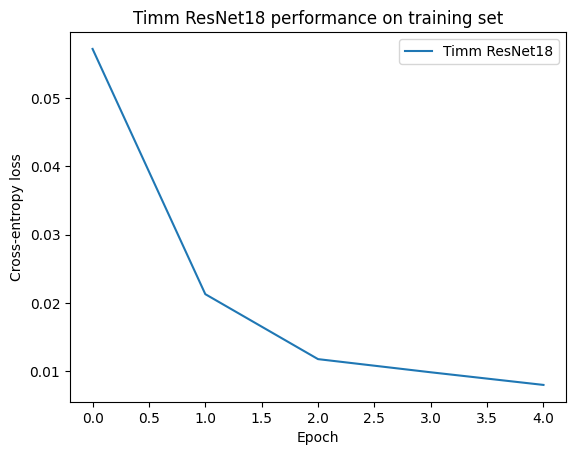

In [104]:
plt.plot(epoch_loss, label='Timm ResNet18')
plt.legend()
plt.title('Timm ResNet18 performance on training set')
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.show()

### 6.3 Evaluating _timm_ model

#### Loading pretrained model

In [30]:
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
timm_model.load_state_dict(torch.load(path+'timm_resnet18'))
timm_model = timm_model.to(device)
timm_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

#### Multiple image prediction test

In [32]:
image_resized = torch.nn.functional.interpolate(test_images[start:stop], (224, 224))

predictions = timm_model(image_resized).softmax(dim=1).detach()
# print(f'Class probabilities:\n{predictions}\n')

classes_np = np.array(classes)
predicted_classes = predictions.argmax(dim=1)
print(f'Predicted classes: {predicted_classes} - {classes_np[predicted_classes.cpu()]}')
print(f'True classes: {test_labels[start:stop]} - {classes_np[test_labels[start:stop].cpu()]}\n')

class_probabilities(predictions, classes)

Predicted classes: tensor([3, 8, 8, 0], device='cuda:0') - ['cat' 'ship' 'ship' 'plane']
True classes: tensor([3, 8, 8, 0], device='cuda:0') - ['cat' 'ship' 'ship' 'plane']

            class_label  class_probabilities
class_index                                 
3                   cat         1.000000e+00
5                   dog         4.630254e-08
6                  frog         1.552651e-08
1                   car         3.698719e-09
2                  bird         1.535815e-09
8                  ship         1.171113e-09
0                 plane         1.032914e-09
9                 truck         1.298936e-10
7                 horse         7.719377e-11
4                  deer         2.024325e-11 

            class_label  class_probabilities
class_index                                 
8                  ship         9.999110e-01
9                 truck         3.810865e-05
0                 plane         2.687428e-05
1                   car         2.349439e-05
7             

#### Prediction accuracy test

In [33]:
total_accuracy_timm = evaluate(test_loader, timm_model, n_classes=10, to_size=224, print_accuracy=False)

In [34]:
resnet18_class_accuracy = accuracy_score_table(total_accuracy_timm, classes)
print(resnet18_class_accuracy)

            class_label  prediction_accuracy
class_index                                 
0                 plane             0.930188
1                   car             0.870710
2                  bird             0.877613
3                   cat             0.866872
4                  deer             0.912806
5                   dog             0.877370
6                  frog             0.968108
7                 horse             0.938351
8                  ship             0.952939
9                 truck             0.971328


### 6.5 Model-to-model accuracy comparison

In [35]:
resnet20_class_accuracy['model'] = 'resnet20 (custom)'
resnet18_class_accuracy['model'] = 'resnet18 (timm pretrained)'

In [36]:
models_accuracy = pd.concat([resnet20_class_accuracy, resnet18_class_accuracy])
display(models_accuracy)

,class_label,prediction_accuracy,model
class_index,,,
0,plane,0.799533,resnet20 (custom)
1,car,0.859570,resnet20 (custom)
2,bird,0.453546,resnet20 (custom)
3,cat,0.719712,resnet20 (custom)
4,deer,0.831786,resnet20 (custom)
5,dog,0.667584,resnet20 (custom)
6,frog,0.866976,resnet20 (custom)
7,horse,0.687833,resnet20 (custom)
8,ship,0.808326,resnet20 (custom)


In [37]:
sns.set(rc={'figure.figsize':(9, 5)});

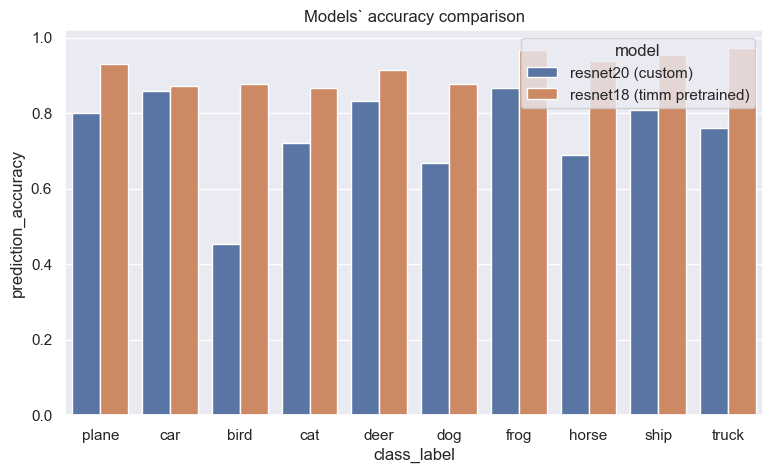

In [42]:
sns.barplot(data=models_accuracy,
            x='class_label', y='prediction_accuracy', hue='model')
plt.title('Models` accuracy comparison')
plt.show()

---
### **Conclusions:**
Timm ResNet18 performed better than custom resnet20 mostly because of transfer learning technique. In other words, we used ResNet18 which is pretrained on ImageNet, and then retrained it to fit CIFAR10 dataset.